# 先把训练集70%、验证集15%、测试集15%的标注文件做好，原始音频切割成3s片段，分好样本集合后随机加噪声。

# 3s分帧加窗，直接在原始音频上处理

In [1]:
import librosa
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.io import wavfile

In [3]:
frame_duration = 3  # 帧时长为秒
# overlap_rate = 0.5  # 帧与帧之间的重叠率为50%
overlap_rate = 0  # 帧与帧之间的重叠率为0%

dir_path = r"X:\数据集\ShipEar\shipsEar_AUDIOS"

wav_paths = glob.glob(os.path.join(dir_path, '*.wav'))

# 定义加窗函数
def apply_window(frame):
    window = np.hanning(len(frame))
    return frame * window

In [4]:
for wav_path in wav_paths:
    dir_name, file_name = os.path.split(wav_path)
    file_name_no_ext = os.path.splitext(file_name)[0]

    # 加载音频
    audio, sr = librosa.load(wav_path, sr=52734)

    # 计算帧的长度和帧移
    frame_length = int(frame_duration * sr)
    hop_length = int(frame_length* (1 - overlap_rate))

    # 填充音频
    total_samples = len(audio)
    if total_samples < frame_length:
        pad_len = frame_length - total_samples
    else:
        remainder = (total_samples - frame_length) % hop_length
        pad_len = 0 if remainder == 0 else hop_length - remainder
    
    audio_padded = np.pad(audio, (0, pad_len), mode="constant") if pad_len > 0 else audio

    # 分帧
    frames = librosa.util.frame(audio_padded, frame_length=frame_length, hop_length=hop_length)

    # 对每帧应用加窗
    frames_windowed = np.apply_along_axis(apply_window, 0, frames)

    output_folder = r"X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz"

    os.makedirs(output_folder, exist_ok=True)

    # 保存加窗后的每帧
    for i, frame_windowed in enumerate(frames_windowed.T):
        output_path = os.path.join(output_folder, f"{file_name_no_ext}_{i+1}.wav")
        wavfile.write(output_path, sr, frame_windowed)
        print(f"Processed: {output_path}")
print("All files processed.")

Processed: X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz\10__10_07_13_marDeOnza_Sale_1.wav
Processed: X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz\10__10_07_13_marDeOnza_Sale_2.wav
Processed: X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz\10__10_07_13_marDeOnza_Sale_3.wav
Processed: X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz\10__10_07_13_marDeOnza_Sale_4.wav
Processed: X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz\10__10_07_13_marDeOnza_Sale_5.wav
Processed: X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz\10__10_07_13_marDeOnza_Sale_6.wav
Processed: X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz\10__10_07_13_marDeOnza_Sale_7.wav
Processed: X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz\10__10_07_13_marDeOnza_Sale_8.wav
Processed: X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz\10__10_07_13_marDeOnza_Sale_9.wav
Processed: X:\数据集\ShipEar\data_preprocessing\7

# 处理标注文件，70/15/15 划分

In [5]:
import os
import pandas as pd
import re

In [6]:
df = pd.read_csv(r"X:\数据集\ShipEar\data_preprocessing\annotation\shipear_group_class_prompt_en.csv")

out_df = pd.DataFrame()
for col in ["ID", "Filename", "Name", "Type", "group_id", "class_id_5", "class_id_12", "Channel Depth", "Wind", "Distance", "prompt_en"]:
    out_df[col] = df[col]

file_directory = r"X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz"

if os.path.exists(file_directory):
    files_in_dir = [os.path.splitext(f)[0] for f in os.listdir(file_directory) if os.path.isfile(os.path.join(file_directory, f))]
    out_df['segmented_filename'] = out_df['Filename'].str.replace('.wav', '', regex=False)

    # 创建原始文件名到信息的映射
    original_file_mapping = {}
    for _, row in out_df.iterrows():
        original_filename = row['Filename']
        original_file_mapping[original_filename] = row.to_dict()
    # 为每个分段文件创建标注记录
    segmented_rows = []
    for segmented_file in files_in_dir:
        parts = segmented_file.split('_')
        original_filename = '_'.join(parts[:-1]) + '.wav'
        segment_number = parts[-1]

        if original_filename in original_file_mapping:
            original_info = original_file_mapping[original_filename]
            segmented_row = original_info.copy()
            segmented_row['segmented_filename'] = segmented_file
            segmented_row['segment_number'] = segment_number
            segmented_rows.append(segmented_row)

    if segmented_rows:
        segmented_df = pd.DataFrame(segmented_rows)
        column_order = ['ID', 'Filename', 'Name', 'Type', 'group_id', 'class_id_5', 'class_id_12', 'segmented_filename', 'segment_number', "Channel Depth", "Wind", "Distance", "prompt_en"]
        segmented_df = segmented_df[column_order]
        output_file = os.path.join(r"X:\数据集\ShipEar\data_preprocessing\annotation", r"shipear_group_class_segmented_prompt_en_5_frame_Windows_16kHz_3s_0%_SNR.csv")
        segmented_df.to_csv(output_file, index=False)
        print(f"已处理 {len(segmented_rows)} 个分段文件")
        print(f"已保存: {output_file}")

已处理 3824 个分段文件
已保存: X:\数据集\ShipEar\data_preprocessing\annotation\shipear_group_class_segmented_prompt_en_5_frame_Windows_16kHz_3s_0%_SNR.csv


In [7]:
from sklearn.model_selection import train_test_split

In [9]:
SPLIT_SEED = 42
VAL_FRACTION = 0.15 / 0.85 

remain_df, test_df = train_test_split(
    segmented_df,
    test_size=0.15,
    random_state=SPLIT_SEED,
    stratify=segmented_df["class_id_5"],
)

train_df, val_df = train_test_split(
    remain_df,
    test_size=VAL_FRACTION,
    random_state=SPLIT_SEED,
    stratify=remain_df["class_id_5"],
)

def add_split_cols(df, split_name):
    return df.assign(split=split_name, split_id=split_map[split_name])

split_map = {"train": 0, "val": 1, "test": 2}
train_df = add_split_cols(train_df, "train")
val_df = add_split_cols(val_df, "val")
test_df = add_split_cols(test_df, "test")

split_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
split_df.to_csv(output_file, index=False)

print(
    f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}, "
    f"saved to {output_file}"
)

Train: 2676, Val: 574, Test: 574, saved to X:\数据集\ShipEar\data_preprocessing\annotation\shipear_group_class_segmented_prompt_en_5_frame_Windows_16kHz_3s_0%_SNR.csv


# 检查标注文件与样本是否一一对应，分别存放在三个子集中

In [6]:
annotation_path = Path(r"X:\数据集\ShipEar\data_preprocessing\annotation\shipear_group_class_segmented_prompt_en_5_frame_Windows_16kHz_3s_0%_SNR.csv")
root_dir = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test")

df = pd.read_csv(annotation_path)
def to_name(row):
    name = str(row.get("segmented_filename", row.get("segment_id")))
    return name if name.lower().endswith(".wav") else f"{name}.wav"
df["wav_name"] = df.apply(to_name, axis=1)

for split in ["train", "val", "test"]:
    expected = set(df.loc[df["split"] == split, "wav_name"])
    actual = {p.name for p in (root_dir / split).glob("*.wav")}
    print(split, "missing_on_disk=", len(expected - actual), "not_listed_in_csv=", len(actual - expected))

train missing_on_disk= 0 not_listed_in_csv= 0
val missing_on_disk= 0 not_listed_in_csv= 0
test missing_on_disk= 0 not_listed_in_csv= 0


# 把训练集、验证集、测试集处理出来用三个文件夹，然后三个文件夹放在一个大文件夹下

In [10]:
import os
import shutil
import pandas as pd
from pathlib import Path
from tqdm import tqdm

In [11]:
ANNOTATION_CSV = Path(r"X:\数据集\ShipEar\data_preprocessing\annotation\shipear_group_class_segmented_prompt_en_5_frame_Windows_16kHz_3s_0%_SNR.csv")
SEGMENT_ROOT = Path(r"X:\数据集\ShipEar\data_preprocessing\7_frame_window_3s_0%_16kHz")
OUTPUT_ROOT = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test") 
SPLIT_DIRS = {"train": OUTPUT_ROOT / "train", "val": OUTPUT_ROOT / "val", "test": OUTPUT_ROOT / "test"}

In [12]:
df = pd.read_csv(ANNOTATION_CSV)

for path in SPLIT_DIRS.values():
    path.mkdir(parents=True, exist_ok=True)

for _, row in tqdm(df.iterrows(), total=len(df)):
    split_name = row["split"]
    fname = f"{row['segmented_filename']}.wav" if not str(row["segmented_filename"]).endswith(".wav") else row["segmented_filename"]
    src = SEGMENT_ROOT / fname
    dst = SPLIT_DIRS[split_name] / fname
    if not src.exists():
        print(f"[WARN] Missing file: {src}")
        continue
    shutil.copy2(src, dst)

print("Done! Files are in", OUTPUT_ROOT)


100%|██████████| 3824/3824 [00:40<00:00, 93.97it/s] 

Done! Files are in X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test


# 训练集随机加噪，验证集、测试集固定噪声分贝数

In [1]:
import os
import math
import json
import shutil
import numpy as np
import soundfile as sf
import pandas as pd
from pathlib import Path
from tqdm import tqdm

In [2]:
SOURCE_ROOT = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test")
ANNOTATION_CSV = Path(r"X:\数据集\ShipEar\data_preprocessing\annotation\shipear_group_class_segmented_prompt_en_5_frame_Windows_16kHz_3s_0%_SNR.csv")
# DEST_ROOT = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset")
DEST_ROOT = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr")
TRAIN_RANGE = (-12, 6)
EVAL_SNRS = np.array([-12, -9, -6, -3, 0, 3, 6], dtype=np.int32)

DEST_ROOT.mkdir(parents=True, exist_ok=True)
df_split = pd.read_csv(ANNOTATION_CSV)

def add_noise_with_snr(signal, target_snr_db, rng):
    signal_power = np.mean(signal ** 2) + 1e-12
    snr_linear = 10 ** (target_snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise = rng.normal(0.0, np.sqrt(noise_power), size=signal.shape)
    return signal + noise

def load_waveform(split, name):
    wav_path = SOURCE_ROOT / split / name
    audio, sr = sf.read(wav_path)
    return audio.astype(np.float32), sr

train_rng = np.random.default_rng(42)

for _, row in tqdm(df_split.iterrows(), total=len(df_split)):
    split = row["split"]
    fname = row["segmented_filename"]
    if not fname.lower().endswith(".wav"):
        fname = f"{fname}.wav"

    audio, sr = load_waveform(split, fname)

    if split == "train":
        # snr = train_rng.integers(TRAIN_RANGE[0], TRAIN_RANGE[1] + 1)
        snr = float(train_rng.uniform(TRAIN_RANGE[0], TRAIN_RANGE[1] + 1e-6))
        snr = min(snr, TRAIN_RANGE[1]) 
        seed = train_rng.integers(0, 2**32 - 1)
        noisy = add_noise_with_snr(audio, snr, np.random.default_rng(seed))

        out_dir = DEST_ROOT / "train"
        out_dir.mkdir(parents=True, exist_ok=True)
        sf.write(out_dir / fname, noisy, sr)

    else:
        for snr in EVAL_SNRS:
            seed_input = f"{fname}-{snr}"
            seed = np.uint32(abs(hash(seed_input)) & 0xFFFFFFFF)
            noisy = add_noise_with_snr(audio, snr, np.random.default_rng(seed))
            snr_dir = DEST_ROOT / split / f"SNR_{snr:+d}dB"
            snr_dir.mkdir(parents=True, exist_ok=True)
            sf.write(snr_dir / fname, noisy, sr)

100%|██████████| 3824/3824 [02:06<00:00, 30.31it/s]


# 测试噪声添加是否正确

In [2]:
import numpy as np
import soundfile as sf
from pathlib import Path
import matplotlib.pyplot as plt

In [39]:
def measure_snr_db(clean_path, noisy_path):
    clean, sr_clean = sf.read(clean_path, dtype="float32")
    noisy, sr_noisy = sf.read(noisy_path, dtype="float32")
    if sr_clean != sr_noisy:
        raise ValueError(f"Sample rate mismatch: {sr_clean} vs {sr_noisy}")

    # 截成相同长度，避免后缀补零差异
    min_len = min(len(clean), len(noisy))
    clean = clean[:min_len]
    noisy = noisy[:min_len]

    noise = noisy - clean
    signal_power = np.mean(clean ** 2) + 1e-12
    noise_power = np.mean(noise ** 2) + 1e-12
    snr_db = 10.0 * np.log10(signal_power / noise_power)
    return snr_db

noisy_path = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset\test\SNR_-6dB\6__10_07_13_marDeCangas_Entra_18.wav")
clean_path = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test\test\6__10_07_13_marDeCangas_Entra_18.wav")

print(f"SNR = {measure_snr_db(clean_path, noisy_path):.2f} dB")

SNR = -6.02 dB


In [41]:
def peak_amplitude(path):
    audio, _ = sf.read(path, dtype="float32")
    return float(np.max(np.abs(audio)))

def compare_peaks(clean_path, noisy_path):
    clean_peak = peak_amplitude(clean_path)
    noisy_peak = peak_amplitude(noisy_path)
    print(f"Clean peak: {clean_peak:.6f}")
    print(f"Noisy peak: {noisy_peak:.6f}")

clean = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test\test\6__10_07_13_marDeCangas_Entra_18.wav")
noisy = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset\test\SNR_-6dB\6__10_07_13_marDeCangas_Entra_18.wav")

compare_peaks(clean, noisy)

Clean peak: 0.014208
Noisy peak: 0.025269


In [6]:
def measure_snr_db(clean_path, noisy_path):
    clean, sr_clean = sf.read(clean_path, dtype="float32")
    noisy, sr_noisy = sf.read(noisy_path, dtype="float32")
    if sr_clean != sr_noisy:
        raise ValueError(f"Sample rate mismatch: {sr_clean} vs {sr_noisy}")

    # 截成相同长度，避免后缀补零差异
    min_len = min(len(clean), len(noisy))
    clean = clean[:min_len]
    noisy = noisy[:min_len]

    noise = noisy - clean
    signal_power = np.mean(clean ** 2) + 1e-12
    noise_power = np.mean(noise ** 2) + 1e-12
    snr_db = 10.0 * np.log10(signal_power / noise_power)
    return snr_db

clean_path = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test\train\6__10_07_13_marDeCangas_Entra_8.wav")
noisy_path = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\train\6__10_07_13_marDeCangas_Entra_8.wav")

print(f"SNR = {measure_snr_db(clean_path, noisy_path):.2f} dB")

SNR = -4.51 dB


In [8]:
def peak_amplitude(path):
    audio, _ = sf.read(path, dtype="float32")
    return float(np.max(np.abs(audio)))

def compare_peaks(clean_path, noisy_path):
    clean_peak = peak_amplitude(clean_path)
    noisy_peak = peak_amplitude(noisy_path)
    print(f"Clean peak: {clean_peak:.6f}")
    print(f"Noisy peak: {noisy_peak:.6f}")

clean = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test\train\6__10_07_13_marDeCangas_Entra_8.wav")
noisy = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\train\6__10_07_13_marDeCangas_Entra_8.wav")

compare_peaks(clean, noisy)

Clean peak: 0.013766
Noisy peak: 0.028137


In [5]:
def measure_snr_db(clean_path, noisy_path):
    clean, sr_clean = sf.read(clean_path, dtype="float32")
    noisy, sr_noisy = sf.read(noisy_path, dtype="float32")
    if sr_clean != sr_noisy:
        raise ValueError(f"Sample rate mismatch: {sr_clean} vs {sr_noisy}")

    # 截成相同长度，避免后缀补零差异
    min_len = min(len(clean), len(noisy))
    clean = clean[:min_len]
    noisy = noisy[:min_len]

    noise = noisy - clean
    signal_power = np.mean(clean ** 2) + 1e-12
    noise_power = np.mean(noise ** 2) + 1e-12
    snr_db = 10.0 * np.log10(signal_power / noise_power)
    return snr_db

clean_path = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test\test\6__10_07_13_marDeCangas_Entra_20.wav")
noisy_path = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\test\SNR_+6dB\6__10_07_13_marDeCangas_Entra_20.wav")

print(f"SNR = {measure_snr_db(clean_path, noisy_path):.2f} dB")

SNR = 6.00 dB


In [6]:
def peak_amplitude(path):
    audio, _ = sf.read(path, dtype="float32")
    return float(np.max(np.abs(audio)))

def compare_peaks(clean_path, noisy_path):
    clean_peak = peak_amplitude(clean_path)
    noisy_peak = peak_amplitude(noisy_path)
    print(f"Clean peak: {clean_peak:.6f}")
    print(f"Noisy peak: {noisy_peak:.6f}")

clean_path = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test\test\6__10_07_13_marDeCangas_Entra_20.wav")
noisy_path = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\test\SNR_+6dB\6__10_07_13_marDeCangas_Entra_20.wav")

compare_peaks(clean_path, noisy_path)

Clean peak: 0.014438
Noisy peak: 0.015411


In [ ]:
def measure_snr_db(clean_path, noisy_path):
    clean, sr_clean = sf.read(clean_path, dtype="float32")
    noisy, sr_noisy = sf.read(noisy_path, dtype="float32")
    if sr_clean != sr_noisy:
        raise ValueError(f"Sample rate mismatch: {sr_clean} vs {sr_noisy}")

    # 截成相同长度，避免后缀补零差异
    min_len = min(len(clean), len(noisy))
    clean = clean[:min_len]
    noisy = noisy[:min_len]

    noise = noisy - clean
    signal_power = np.mean(clean ** 2) + 1e-12
    noise_power = np.mean(noise ** 2) + 1e-12
    snr_db = 10.0 * np.log10(signal_power / noise_power)
    return snr_db

clean_path = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test\val\8__10_07_13_marDeOnza_Entra_16.wav")
noisy_path = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\val\SNR_+6dB\8__10_07_13_marDeOnza_Entra_16.wav")

print(f"SNR = {measure_snr_db(clean_path, noisy_path):.2f} dB")

SNR = 5.99 dB


In [ ]:
def peak_amplitude(path):
    audio, _ = sf.read(path, dtype="float32")
    return float(np.max(np.abs(audio)))

def compare_peaks(clean_path, noisy_path):
    clean_peak = peak_amplitude(clean_path)
    noisy_peak = peak_amplitude(noisy_path)
    print(f"Clean peak: {clean_peak:.6f}")
    print(f"Noisy peak: {noisy_peak:.6f}")

clean_path = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test\val\8__10_07_13_marDeOnza_Entra_16.wav")
noisy_path = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\val\SNR_+6dB\8__10_07_13_marDeOnza_Entra_16.wav")

compare_peaks(clean_path, noisy_path)

Clean peak: 0.030742
Noisy peak: 0.033417


In [4]:
def inspect_powers(clean_path, noisy_path, target_db=6.0):
    clean, sr = sf.read(clean_path, dtype="float32")
    noisy, sr2 = sf.read(noisy_path, dtype="float32")
    if sr != sr2:
        raise ValueError(f"Sample rate mismatch: {sr} vs {sr2}")

    min_len = min(len(clean), len(noisy))
    clean = clean[:min_len]
    noisy = noisy[:min_len]

    noise = noisy - clean
    signal_power = float(np.mean(clean ** 2))
    noise_power = float(np.mean(noise ** 2))
    ratio = signal_power / noise_power
    expected = 10 ** (target_db / 10.0)

    print(f"signal_power = {signal_power:.8e}")
    print(f"noise_power  = {noise_power:.8e}")
    print(f"ratio        = {ratio:.5f}")
    print(f"10^(SNR/10)  = {expected:.5f}")

clean = Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test\val\8__10_07_13_marDeOnza_Entra_16.wav")
noisy = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\val\SNR_+6dB\8__10_07_13_marDeOnza_Entra_16.wav")
inspect_powers(clean, noisy, target_db=6.0)

signal_power = 2.32950042e-05
noise_power  = 5.86444412e-06
ratio        = 3.97224
10^(SNR/10)  = 3.98107


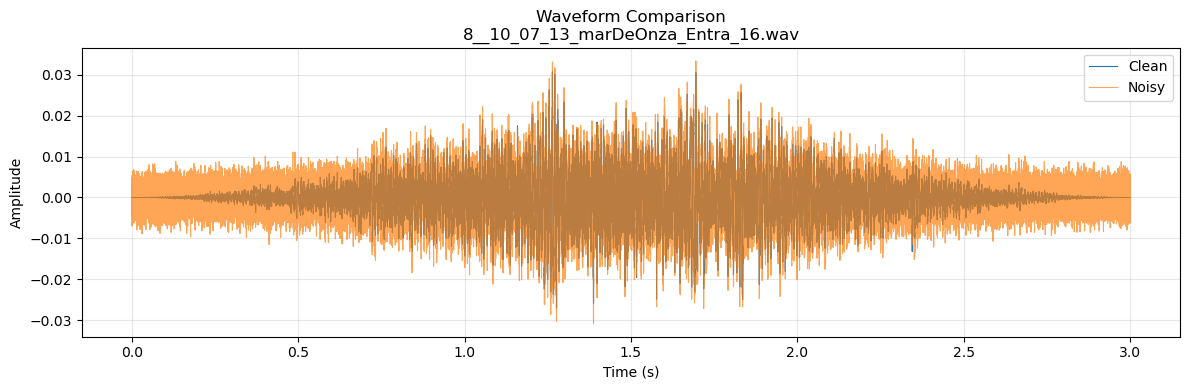

In [3]:
def plot_clean_vs_noisy(clean_path: Path | str, noisy_path: Path | str):
    clean, sr_clean = sf.read(clean_path, dtype="float32")
    noisy, sr_noisy = sf.read(noisy_path, dtype="float32")
    if sr_clean != sr_noisy:
        raise ValueError(f"采样率不一致: clean={sr_clean}, noisy={sr_noisy}")
    t = np.arange(len(clean)) / sr_clean

    plt.figure(figsize=(12, 4))
    plt.plot(t, clean, label="Clean", linewidth=0.8)
    plt.plot(t, noisy, label="Noisy", linewidth=0.8, alpha=0.7)
    plt.title(f"Waveform Comparison\n{Path(clean_path).name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_clean_vs_noisy(
    Path(r"X:\数据集\ShipEar\data_preprocessing\8_frame_window_3s_0%_16kHz_train_val_test\val\8__10_07_13_marDeOnza_Entra_16.wav"),
    Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\val\SNR_+6dB\8__10_07_13_marDeOnza_Entra_16.wav"),
)

# 提取特征

In [9]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from pathlib import Path

In [10]:
SAMPLE_RATE = 16000
# SAMPLE_RATE = 48000
N_MEL = 128
N_MFCC = 40 
N_FFT = 2048
HOP_LENGTH = 512

In [11]:
def extract_mel_npy(in_dir, out_dir, samplerate, n_mels, n_fft, hop_length):
    os.makedirs(out_dir, exist_ok=True)
  
    for wav in glob.glob(os.path.join(in_dir, '*.wav')):
        y, sr = librosa.load(wav, sr=samplerate)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        filename = os.path.splitext(os.path.basename(wav))[0]
        output_path = os.path.join(out_dir, f"{filename}.npy")
        np.save(output_path, mel_db)

def extract_mfcc_npy(in_dir, out_dir, samplerate, n_mfcc):
    os.makedirs(out_dir, exist_ok=True)

    for wav in glob.glob(os.path.join(in_dir, '*.wav')):
        y, sr = librosa.load(wav, sr=samplerate)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        filename = os.path.splitext(os.path.basename(wav))[0]
        output_path = os.path.join(out_dir, f"{filename}.npy")
        np.save(output_path, mfcc)

In [12]:
# INPUT_ROOT = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset")
# OUTPUT_ROOT = Path(r"X:\数据集\ShipEar\data_preprocessing\10_frame_window_3s_0%_16kHz_noisy_dataset_feature")
INPUT_ROOT = Path(r"X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr")
OUTPUT_ROOT = Path(r"X:\数据集\ShipEar\data_preprocessing\10_frame_window_3s_0%_16kHz_noisy_dataset_float_snr_feature")
SPLITS = ["train", "val", "test"]

def save_array(target_path, array):
    target_path.parent.mkdir(parents=True, exist_ok=True)
    np.save(target_path, array)

for split in SPLITS:
    split_in = INPUT_ROOT / split
    split_out = OUTPUT_ROOT / split

    for wav_path in split_in.rglob("*.wav"):
        y, sr = librosa.load(wav_path, sr=SAMPLE_RATE)

        # Mel
        mel = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=N_MEL, n_fft=N_FFT, hop_length=HOP_LENGTH
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)

        # 波形直接存
        waveform = y.astype(np.float32)

        rel = wav_path.relative_to(split_in).with_suffix(".npy")
        save_array(split_out / "mel" / rel, mel_db)
        save_array(split_out / "mfcc" / rel, mfcc)
        save_array(split_out / "waveform" / rel, waveform)

        print(f"[{split}] {wav_path} -> features saved")

[train] X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\train\10__10_07_13_marDeOnza_Sale_1.wav -> features saved
[train] X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\train\10__10_07_13_marDeOnza_Sale_13.wav -> features saved
[train] X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\train\10__10_07_13_marDeOnza_Sale_14.wav -> features saved
[train] X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\train\10__10_07_13_marDeOnza_Sale_16.wav -> features saved
[train] X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\train\10__10_07_13_marDeOnza_Sale_17.wav -> features saved
[train] X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_snr\train\10__10_07_13_marDeOnza_Sale_18.wav -> features saved
[train] X:\数据集\ShipEar\data_preprocessing\9_frame_window_3s_0%_16kHz_noisy_dataset_float_